In [0]:
import json
import os
token = {"username":"vinaybhupalam","key":"5c27e8b73e30502d96da3d5b41a37fed"}
os.mkdir('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w+') as file:
    json.dump(token, file)

In [42]:
import os
import shutil
import glob
import keras
from skimage import io
from skimage.transform import resize
import os
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.simplefilter('ignore')
print("DOne")

DOne


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:44<00:00, 32.9MB/s]
100% 2.29G/2.29G [00:44<00:00, 55.0MB/s]


In [5]:
!ls

chest-xray-pneumonia.zip  sample_data


In [0]:
!unzip chest-xray-pneumonia.zip

In [7]:
!ls

chest_xray  chest-xray-pneumonia.zip  sample_data


In [0]:
DATASET_PATH = '/content/chest_xray'

# There are two classes of images that we will deal with
disease_cls = ['NORMAL' ,'PNEUMONIA'              
              ]

In [9]:
!ls

chest_xray  chest-xray-pneumonia.zip  sample_data


In [0]:
cd content

[Errno 2] No such file or directory: 'content'
/content


Number of data points for Label 1341  is NORMAL
Number of data points for Label 3875  is PNEUMONIA
(680, 1024)


(256, 256)

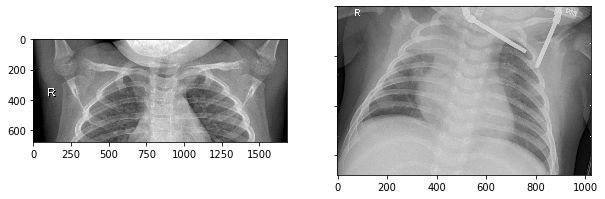

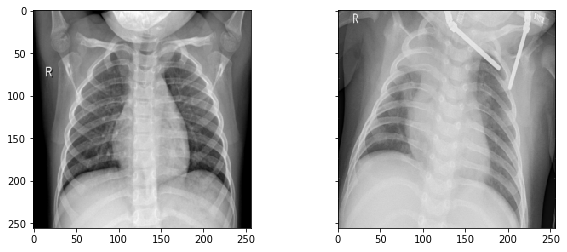

In [10]:
import glob
for index,class_type in enumerate(disease_cls):
    path = os.path.join(DATASET_PATH, 'train', disease_cls[index], '*')
    count_datapoints = len(glob.glob(path))
    print("Number of data points for Label {}  is {}" .format(count_datapoints,class_type))


Normal_path = os.path.join(DATASET_PATH, 'train', disease_cls[0], '*')
Normal = glob.glob(Normal_path)
Normal = io.imread(Normal[0],True)
Pnuemonia_path = os.path.join(DATASET_PATH, 'train', disease_cls[1], '*')
Pnuemonia = glob.glob(Pnuemonia_path)
Pnuemonia = io.imread(Pnuemonia[0],True)

print(Pnuemonia.shape)
f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(Normal, cmap='gray')
axes[1].imshow(Pnuemonia, cmap='gray')


image_resized_Normal = resize(Normal, (256, 256))
image_resized_Pneumonia = resize(Pnuemonia, (256, 256))
f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
axes[0].imshow(image_resized_Normal, cmap='gray')
axes[1].imshow(image_resized_Pneumonia, cmap='gray')

image_resized_Normal.shape

In [0]:
from skimage.transform import rescale
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    
    img = resize(img, (256, 256))
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd content

[Errno 2] No such file or directory: 'content'
/content/drive/My Drive


In [13]:
cd drive/My\ Drive

/content/drive/My Drive


In [15]:
!ls

 Album
'A Textbook of Electrical Technology Volume II - AC and DC machines - B.L. Thferaja.pdf'
 audio_server_gstreamer.c.gdoc
'BPB Publications - Test Your C Skills.pdf'
'C8_Group Call'
 cmd.exe
'Colab Notebooks'
'complete cpp .txt'
'Degree_Certificate - Vinaybm Bhupalam.zip'
 Degree_Certificate.zip
 Engagement
 mysore.mdl
'New Doc 2017-09-11 (3)_1.pdf'
'ni (shortlist) 2014 batch.gsheet'
 __pycache__
'resnet_modified (1).py'
 resnet_modified.py
 resnet.py
 ResNext.py
'students list.gsheet'
 SWING1.DAT
'tcs latest.gsheet'


In [14]:
cd content

[Errno 2] No such file or directory: 'content'
/content/drive/My Drive


In [16]:
#import resnet_modified
#model = resnet_modified.ResnextBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
from google.colab import files
upload= files.upload()

Saving resnet_modified.py to resnet_modified (2).py


In [24]:
!ls

chest_xray  chest-xray-pneumonia.zip  drive  sample_data


In [25]:
cd ~/

/root


In [27]:
cd ..

/


In [28]:
cd content

/content


In [34]:
!ls

 Album
'A Textbook of Electrical Technology Volume II - AC and DC machines - B.L. Thferaja.pdf'
 audio_server_gstreamer.c.gdoc
'BPB Publications - Test Your C Skills.pdf'
'C8_Group Call'
 cmd.exe
'Colab Notebooks'
'complete cpp .txt'
'Degree_Certificate - Vinaybm Bhupalam.zip'
 Degree_Certificate.zip
 Engagement
 mysore.mdl
'New Doc 2017-09-11 (3)_1.pdf'
'ni (shortlist) 2014 batch.gsheet'
 __pycache__
'resnet_modified (1).py'
'resnet_modified (2).py'
 resnet_modified.py
 resnet.py
 ResNext.py
'students list.gsheet'
 SWING1.DAT
'tcs latest.gsheet'


In [0]:
import resnet_modified

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [0]:
import numpy as np
import keras

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['NORMAL', 'PNEUMONIA'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            print(cls)
            paths = glob.glob(os.path.join(DATASET_PATH,'train', cls, '*')) 
            brk_point = int(len(paths)*0.8)           
            if self.mode == 'train':         
                paths = paths[:brk_point]
            elif self.mode == 'validation':
                paths = paths[brk_point:]
            elif self.mode == 'test':
                paths = glob.glob(os.path.join(DATASET_PATH, "test", cls, '*'))    
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            print(len(paths) ,cls,self.mode)
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID,True)
            img = img[:, :, np.newaxis]            
            img = preprocess_img(img, self.mode)
            X[i,] = img
            y[i] = self.labels[ID]         
              
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        # from sklearn.utils import class_weight
        # global class_weight
        # class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
        # print(class_weight)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [38]:

model = resnet_modified.ResnextBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes,3)
from keras import optimizers
sgd_momentum = optimizers.SGD(lr=0.005 ,momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=sgd_momentum,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=20 ,disease_cls=disease_cls)
validation_generator = AugmentedDataGenerator('validation', ablation=20,disease_cls = disease_cls)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=5)
















NORMAL
214 NORMAL train
PNEUMONIA
620 PNEUMONIA train
NORMAL
53 NORMAL validation
PNEUMONIA
155 PNEUMONIA validation
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
26/26 [==============================] - 84s 3s/step - loss: 2.5340 - acc: 0.7981
Epoch 2/5
26/26 [==============================] - 76s 3s/step - loss: 2.4646 - acc: 0.8425
Epoch 3/5
26/26 [==============================] - 76s 3s/step - loss: 2.3349 - acc: 0.9123
Epoch 4/5
26/26 [==============================] - 77s 3s/step - loss: 2.2974 - acc: 0.9363
Epoch 5/5
26/26 [==============================] - 77s 3s/step - loss: 2.2740 - acc: 0.9423


In [0]:
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [0]:
from sklearn.metrics import roc_auc_score, recall_score
from keras import optimizers
from keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)        
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [0]:
model = resnet_modified.ResnextBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes,3)
sgd = optimizers.SGD(lr=0.01,momentum=0.9)

model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=100)
validation_generator = AugmentedDataGenerator('validation', ablation=100)

auc_logger = roc_callback()
decay = DecayLR()

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=7, callbacks=[auc_logger, decay])

NORMAL
1072 NORMAL train
PNEUMONIA
3100 PNEUMONIA train
NORMAL
269 NORMAL validation
PNEUMONIA
775 PNEUMONIA validation
Epoch 1/7
115/130 [=========================>....] - ETA: 47s - loss: 2.3988 - acc: 0.8793